In [2]:
import geopandas as gpd
import pandas as pd

# File paths
county_shapefile_path = "/Users/mharoonashfaq/NJ_Transit_Project/data/County_Boundaries_of_NJ.shp"
bus_terminals_csv_path = "/Users/mharoonashfaq/NJ_Transit_Project/data/Bus_Terminals_of_NJ_Transit (1).csv"

# Load the NJ counties shapefile
nj_counties = gpd.read_file(county_shapefile_path)
print("NJ Counties Data:")
print(nj_counties.head())

# Load the bus terminals CSV
bus_terminals = pd.read_csv(bus_terminals_csv_path)
print("\nBus Terminals Data:")
print(bus_terminals.head())

NJ Counties Data:
   OBJECTID      COUNTY         COUNTY_LAB   CO             GNIS_NAME    GNIS  \
0         1    ATLANTIC    Atlantic County  ATL    County of Atlantic  882270   
1         2      BERGEN      Bergen County  BER      County of Bergen  882271   
2         3  BURLINGTON  Burlington County  BUR  County of Burlington  882272   
3         4      CAMDEN      Camden County  CAM      County of Camden  882273   
4         5    CAPE MAY    Cape May County  CAP    County of Cape May  882274   

  FIPSSTCO FIPSCO          ACRES    SQ_MILES  ...  POPDEN2000  POPDEN1990  \
0    34001      1  390813.840968  610.646627  ...         414         451   
1    34003      3  153489.661221  239.827596  ...        3686        3459   
2    34005      5  524901.239973  820.158187  ...         516         482   
3    34007      7  145597.905686  227.496728  ...        2237        2341   
4    34009      9  183125.841721  286.134128  ...         358         332   

   POPDEN1980        REGION     

In [3]:
from shapely.geometry import Point

# Ensure both datasets have the same CRS
print("NJ Counties CRS:", nj_counties.crs)

# Convert bus terminals to a GeoDataFrame
geometry = [Point(xy) for xy in zip(bus_terminals['LONGITUDE'], bus_terminals['LATITUDE'])]
bus_terminals_gdf = gpd.GeoDataFrame(bus_terminals, geometry=geometry, crs="EPSG:4326")

# Reproject bus terminals to match the counties CRS if necessary
if bus_terminals_gdf.crs != nj_counties.crs:
    bus_terminals_gdf = bus_terminals_gdf.to_crs(nj_counties.crs)

print("Bus Terminals GeoDataFrame:")
print(bus_terminals_gdf.head())

NJ Counties CRS: EPSG:3424
Bus Terminals GeoDataFrame:
             X            Y  OBJECTID        COUNTY   LATITUDE  LONGITUDE  \
0  197294.4163  223931.6682         1  New York, NY  40.848999 -73.939099   
1  169557.1756  231962.9245         2       Passaic  40.922456 -74.267799   
2  186926.5668  210784.5195         3        Hudson  40.731134 -74.062833   
3  178440.7591  211144.7844         4         Essex  40.734715 -74.163276   
4  173049.1769  210205.9071         5         Essex  40.726428 -74.227144   

        TYPE                      OWNER                   OPERATOR PARKING  \
0   Terminal  Port Authority of NY & NJ  Port Authority of NY & NJ      No   
1  Park/Ride                     NJ DOT                 NJ Transit     Yes   
2   Terminal  Port Authority of NY & NJ  Port Authority of NY & NJ      No   
3   Terminal                 NJ Transit                 NJ Transit      No   
4   Terminal                 NJ Transit                 NJ Transit     Yes   

             

In [5]:
print(bus_terminals_with_county.columns)

Index(['X', 'Y', 'OBJECTID_left', 'COUNTY_left', 'LATITUDE', 'LONGITUDE',
       'TYPE', 'OWNER', 'OPERATOR', 'PARKING', 'NAME', 'MUNICIPALITY',
       'TICKET_SELLER', 'ORIG_FID', 'SE_ANNO_CAD_DATA', 'geometry',
       'index_right', 'OBJECTID_right', 'COUNTY_right', 'COUNTY_LAB', 'CO',
       'GNIS_NAME', 'GNIS', 'FIPSSTCO', 'FIPSCO', 'ACRES', 'SQ_MILES',
       'POP2010', 'POP2000', 'POP1990', 'POP1980', 'POPDEN2010', 'POPDEN2000',
       'POPDEN1990', 'POPDEN1980', 'REGION', 'GLOBALID', 'Shape_Leng',
       'Shape_Area', 'POP2020', 'POPDEN2020'],
      dtype='object')


In [6]:
# Perform spatial join to add county information to bus terminals
bus_terminals_with_county = gpd.sjoin(bus_terminals_gdf, nj_counties, how="inner", predicate="within")

# Group by the correct county column and count terminals
bus_terminal_counts = bus_terminals_with_county.groupby('COUNTY_right').size().reset_index(name='Bus_Terminals_Count')

# Merge this information back into the NJ counties GeoDataFrame
nj_counties = nj_counties.merge(bus_terminal_counts, left_on='COUNTY', right_on='COUNTY_right', how='left')

# Fill missing values with 0 for counties with no bus terminals
nj_counties['Bus_Terminals_Count'] = nj_counties['Bus_Terminals_Count'].fillna(0)

# Inspect the updated GeoDataFrame
print("Updated NJ Counties with Bus Terminal Counts:")
print(nj_counties[['COUNTY', 'Bus_Terminals_Count']])

Updated NJ Counties with Bus Terminal Counts:
        COUNTY  Bus_Terminals_Count
0     ATLANTIC                  1.0
1       BERGEN                  4.0
2   BURLINGTON                  1.0
3       CAMDEN                  2.0
4     CAPE MAY                  4.0
5   CUMBERLAND                  1.0
6        ESSEX                  2.0
7   GLOUCESTER                  0.0
8       HUDSON                  3.0
9    HUNTERDON                  1.0
10      MERCER                  0.0
11    MONMOUTH                  4.0
12       OCEAN                  3.0
13     PASSAIC                 10.0
14       SALEM                  0.0
15    SOMERSET                  1.0
16      SUSSEX                  2.0
17       UNION                  0.0
18      WARREN                  0.0
19      MORRIS                  0.0
20   MIDDLESEX                  1.0


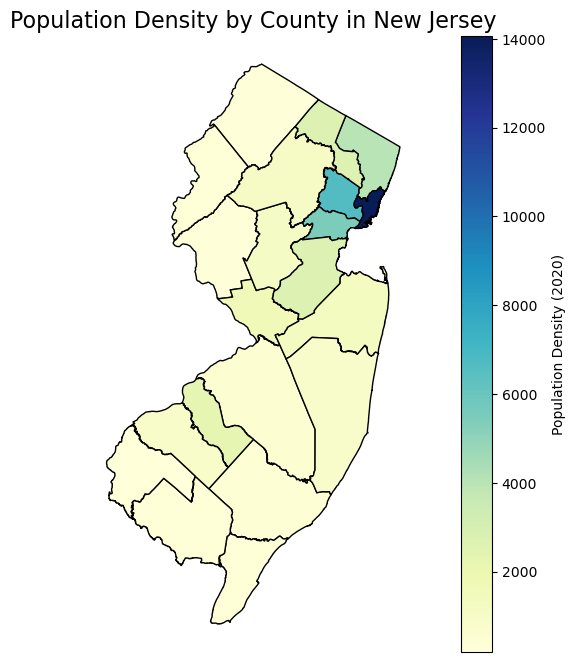

In [7]:
import matplotlib.pyplot as plt

# Plot population density
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
nj_counties.plot(
    column='POPDEN2020',
    cmap='YlGnBu',
    legend=True,
    legend_kwds={'label': "Population Density (2020)"},
    edgecolor='black',
    ax=ax
)
ax.set_title('Population Density by County in New Jersey', fontsize=16)
ax.axis('off')

# Save the static map
plt.savefig('/Users/mharoonashfaq/NJ_Transit_Project/maps/population_density_map.png')
plt.show()

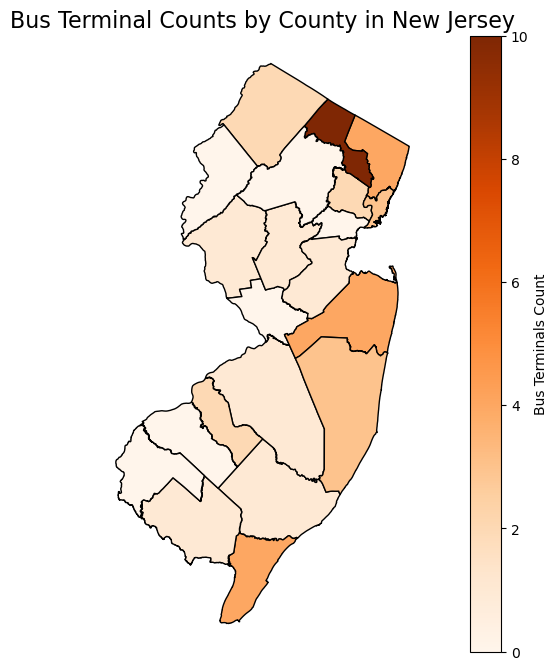

In [8]:
# Plot bus terminal counts
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
nj_counties.plot(
    column='Bus_Terminals_Count',
    cmap='Oranges',
    legend=True,
    legend_kwds={'label': "Bus Terminals Count"},
    edgecolor='black',
    ax=ax
)
ax.set_title('Bus Terminal Counts by County in New Jersey', fontsize=16)
ax.axis('off')

# Save the static map
plt.savefig('/Users/mharoonashfaq/NJ_Transit_Project/maps/bus_terminal_counts_map.png')
plt.show()

In [11]:
import folium
from folium import Choropleth, Marker, LayerControl

# Create a base map
m = folium.Map(location=[40.0583, -74.4057], zoom_start=8, tiles="CartoDB positron")

# Add population density choropleth
Choropleth(
    geo_data=nj_counties,
    name="Population Density",
    data=nj_counties,
    columns=["COUNTY", "POPDEN2020"],
    key_on="feature.properties.COUNTY",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Population Density (2020)"
).add_to(m)

# Add bus terminal markers
for idx, row in bus_terminals_gdf.iterrows():
    Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Name: {row['NAME']}",
        tooltip="Bus Terminal",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

# Add layer control
LayerControl().add_to(m)

# Save the interactive map
m.save('/Users/mharoonashfaq/NJ_Transit_Project/website/interactive_map.html')

In [12]:
import folium
from folium import Choropleth, LayerControl, Marker, Popup

# Create base map
m = folium.Map(location=[40.0583, -74.4057], zoom_start=8, tiles="CartoDB positron")

# Add choropleth for population density
Choropleth(
    geo_data=nj_counties,  # GeoDataFrame with geometry
    name="Population Density",
    data=nj_counties,
    columns=["COUNTY", "POPDEN2020"],  # Columns for county and population density
    key_on="feature.properties.COUNTY",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Population Density (2020)",
).add_to(m)

# Add markers for bus terminals
for idx, row in bus_terminals_with_county.iterrows():
    Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=Popup(f"<b>Name:</b> {row['NAME']}<br><b>Municipality:</b> {row['MUNICIPALITY']}", max_width=300),
        tooltip="Bus Terminal",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

# Add layer control
LayerControl().add_to(m)

# Save the map
m.save('/Users/mharoonashfaq/NJ_Transit_Project/website/interactive_map.html')

In [20]:
ltc_facilities_df = pd.read_csv(ltc_facilities_path)
print(ltc_facilities_df.columns)

Index(['OBJECTID', 'FacilityIdentifier', 'FacilityName', 'Address1',
       'Address2', 'City', 'FacilityType', 'x', 'y'],
      dtype='object')


In [21]:
import geopandas as gpd
import pandas as pd

# Load LTC facilities data
ltc_facilities_path = "/Users/mharoonashfaq/NJ_Transit_Project/data/NJ_Long_Term_Care_Facilities_-8023457001035363343.csv"
ltc_facilities_df = pd.read_csv(ltc_facilities_path)

# Rename x and y columns to LATITUDE and LONGITUDE
ltc_facilities_df.rename(columns={"x": "LONGITUDE", "y": "LATITUDE"}, inplace=True)

# Convert LTC facilities data to GeoDataFrame
ltc_facilities_gdf = gpd.GeoDataFrame(
    ltc_facilities_df,
    geometry=gpd.points_from_xy(ltc_facilities_df.LONGITUDE, ltc_facilities_df.LATITUDE),
    crs="EPSG:4326"
)

# Verify the GeoDataFrame
print(ltc_facilities_gdf.head())

   OBJECTID FacilityIdentifier                              FacilityName  \
0         1            NJ25045       Pace-Life Connection At Atlanticare   
1         2            3130300    Bacharach Institute For Rehabilitation   
2         3            NJ69830  Acuity Specialty Hospital Of New  Jersey   
3         4           NJ01A006            Seashore Gardens Living Center   
4         5            NJ1A001                          Woodview Estates   

                    Address1                                Address2  \
0           2801 Pacific Ave                                     NaN   
1     61 W Jimmie Leeds Road                                     NaN   
2        1925 Pacific Avenue  5th Floor Wellness/Friendship Pavilion   
3  22 West Jimmie Leeds Road                                     NaN   
4       5030 Unami Boulevard                                     NaN   

                City               FacilityType      LONGITUDE       LATITUDE  \
0      Atlantic City         

In [22]:
import folium
from folium import Choropleth, Marker, Popup, LayerControl

# Create a base map
m_combined = folium.Map(location=[40.0583, -74.4057], zoom_start=8, tiles="CartoDB positron")

# Add population density choropleth
Choropleth(
    geo_data=nj_counties,
    name="Population Density",
    data=nj_counties,
    columns=["COUNTY", "POPDEN2020"],
    key_on="feature.properties.COUNTY",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Population Density (2020)"
).add_to(m_combined)

# Add LTC facility markers
for idx, row in ltc_facilities_gdf.iterrows():
    Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=Popup(f"<b>Name:</b> {row['FacilityName']}<br><b>Type:</b> {row['FacilityType']}", max_width=300),
        tooltip="LTC Facility",
        icon=folium.Icon(color="green", icon="plus-sign")
    ).add_to(m_combined)

# Add bus terminal markers
for idx, row in bus_terminals_gdf.iterrows():
    Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=Popup(f"<b>Name:</b> {row['NAME']}<br><b>Type:</b> {row['TYPE']}", max_width=300),
        tooltip="Bus Terminal",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m_combined)

# Add layer control
LayerControl().add_to(m_combined)

# Save the map
m_combined.save("/Users/mharoonashfaq/NJ_Transit_Project/website/combined_map.html")

# Display success message
print("Interactive map created and saved as 'combined_map.html'.")

Interactive map created and saved as 'combined_map.html'.
